In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset, Image
import torch
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import torch.nn as nn
from vae_reimplement.vae import VAE
from vae_reimplement.models import CNNDecoder, CNNEncoder
dataset = load_dataset("cifar10")

In [3]:
from torchvision.transforms import v2


class CustomAddEpsilonNoise(object):
    def __init__(self, epsilon_noise):
        self.epsilon_noise = epsilon_noise
    def __call__(self, sample):
        noise = torch.randn_like(sample) / 255 * self.epsilon_noise 
        sample = torch.clamp_(sample + noise, torch.zeros_like(sample), torch.ones_like(sample))
        return sample

jitter_color = v2.Compose([
    v2.ToImageTensor(),
    v2.ConvertImageDtype(dtype=torch.float32),
    # v2.Lambda(lambda image: image.permute(1,2,0)),
    CustomAddEpsilonNoise(1),
    v2.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

label_names = dataset['train'].features['label'].names
def transform(examples):
    """transforms are best applied only once but why do we have the images represented in the PIL Image format instead of converting them to numpy arrays directly."""
    examples['pixel_values'] = [jitter_color(image) for image in examples["img"]]
    examples['label_string'] = [label_names[l] for l in examples["label"]]
    return examples
dataset.set_transform(transform)

/srv/flash2/jbjorner3/miniconda3/envs/tome/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/srv/flash2/jbjorner3/miniconda3/envs/tome/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [4]:
# dataset.map(lambda batch: batch, batch_size=10)
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset["train"], batch_size=64, shuffle=True)

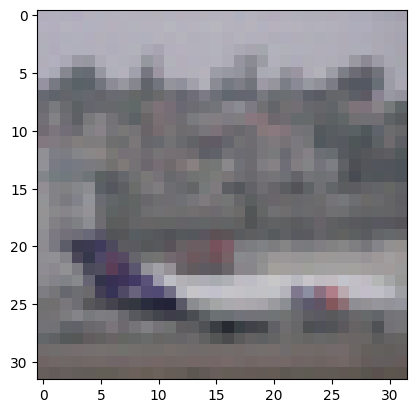

In [6]:
img = dataset["train"][0]['pixel_values'].permute(1,2,0) / 2 + 0.5

plt.imshow(img)
plt.show()

In [7]:
from torch.optim import AdamW

In [8]:
# to train a VAE, need to sample from the model, and compute the loss based on the 
# log likelihood of the image produced as well as the posterior's distance from the prior.
epochs = 10
batch_size = 100
lr = 0.0001
device ="cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
def batches_iterator(dataset_train, batch_size):
    len_dataset = len(dataset_train)
    num_passed = 0
    while num_passed < len_dataset:
        batch = dataset_train[num_passed: min(num_passed + batch_size, len_dataset)]
        num_passed += batch_size
        yield batch
model = VAE(5, 1, 1, image_HW=32, image_channels=3, reconstruction_type="MSE", encoder=CNNEncoder(image_HW=32, image_channels=3, prior_dim=5).to(device), decoder=CNNDecoder(image_HW=32, image_channels=3, prior_dim=5).to(device))
# model.trian()

In [9]:
from torch.optim.lr_scheduler import ExponentialLR

In [10]:
optimizer = AdamW(model.parameters(), lr=lr/10)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [11]:
from collections import defaultdict

In [12]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [13]:
global_steps = 0
loss_list = []
metrics = defaultdict(list)

for epoch in tqdm.tqdm(range(epochs)):
    batches = batches_iterator(dataset["train"], batch_size)
    for step, batch in tqdm.tqdm(enumerate(batches), total=len(dataset['train']) // batch_size):
        optimizer.zero_grad()
        labels = torch.tensor(batch["label"]).to(device)
        images = torch.stack(batch["pixel_values"]).to(device)
        global_steps += 1
        losses = model.loss(images)
        for key in losses:
            metrics[key + '_list'].append(losses[key].item())
        loss = losses["loss"]
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()
    scheduler.step()
    loss_list = []
    print(metrics)
    avg_metrics = {"mean_" + metric_key.replace("_list", ""): sum(metric_list)/len(metric_list) for metric_key, metric_list in metrics.items()}
    print(avg_metrics)
    metrics = defaultdict(list)
    print(f"{epoch=} done with {global_steps=} completed")

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:18<02:50, 18.90s/it]

defaultdict(<class 'list'>, {'loss_list': [840.113525390625, 786.8499145507812, 779.291259765625, 785.9688720703125, 860.973388671875, 741.5023193359375, 871.8977661132812, 863.3560791015625, 725.4911499023438, 796.60302734375, 765.0760498046875, 784.286865234375, 830.5355834960938, 812.8826293945312, 733.8374633789062, 837.8599243164062, 795.8184204101562, 806.3176879882812, 752.5838623046875, 863.6083984375, 778.167724609375, 820.265380859375, 831.0709228515625, 847.156982421875, 828.5196533203125, 664.1009521484375, 732.8803100585938, 710.2840576171875, 750.3765258789062, 830.068115234375, 770.5714721679688, 867.9534301757812, 784.9362182617188, 722.3569946289062, 764.2000122070312, 699.6621704101562, 794.5143432617188, 775.5086669921875, 844.0361328125, 823.0215454101562, 777.8123779296875, 795.4913940429688, 806.3032836914062, 791.4986572265625, 801.6029663085938, 822.0274658203125, 763.4017944335938, 771.3870849609375, 775.3798217773438, 755.9802856445312, 839.3064575195312, 749.

 10%|█         | 1/10 [00:27<04:07, 27.51s/it]


KeyboardInterrupt: 

tensor([[0.5557, 0.5606, 0.5068,  ..., 0.4700, 0.4911, 0.5104]],
       device='cuda:0')


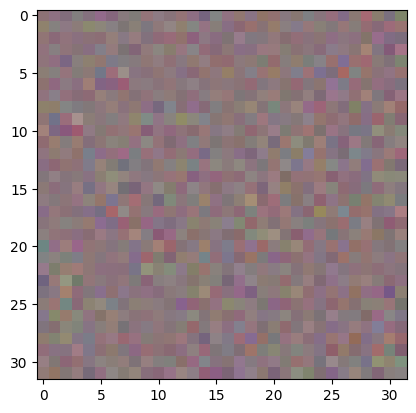

tensor([[0.5477, 0.5764, 0.4995,  ..., 0.4609, 0.5062, 0.4686]],
       device='cuda:0')


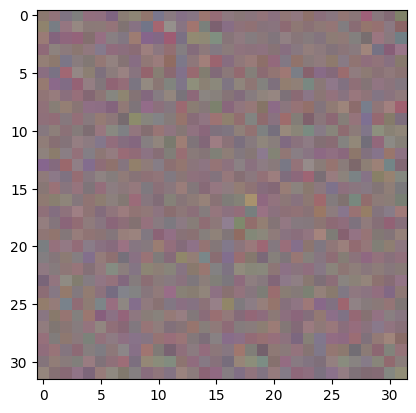

tensor([[0.5518, 0.5656, 0.5281,  ..., 0.4367, 0.4659, 0.4848]],
       device='cuda:0')


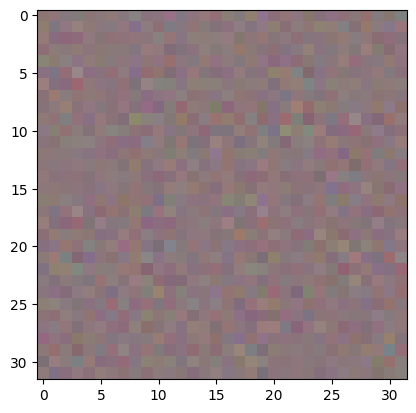

tensor([[0.5497, 0.5745, 0.5060,  ..., 0.4421, 0.4439, 0.5004]],
       device='cuda:0')


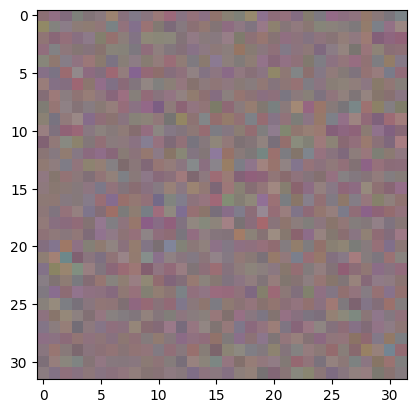

In [15]:
import matplotlib.pyplot as plt
def get_images_from_model_and_display(model, num_images=4):
    priors = torch.randn((num_images, model.prior_dim), dtype=torch.float32, device=device).clamp_(-2,2)
    with torch.no_grad():
        image_x_give_z_mu = model.sample_images(num_images)
        # data_dist = torch.distributions.normal.Normal(image_x_give_z_mu, torch.exp(0.5 * image_x_give_z_sigma_log))
        # images = data_dist.sample().chunk(num_images, dim=0)
        images = image_x_give_z_mu.chunk(num_images, dim=0)
        for image in images:
            print(image)
            plt.imshow(image.cpu().reshape(3,32,32).permute(1,2,0))
            plt.show()
get_images_from_model_and_display(model)